In [18]:
"""Compairison of dRNA on Fibroblasts, two different protocols"""

import pandas as pd
import numpy as np
import pyranges as pr
import os
import sys  
import pysam
import scipy
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser

import matplotlib.pyplot as plt
import seaborn as sns


# Bamstats

In [2]:
results_path = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/direct_RNA_protocol_compairison_2023/"
sub_path = "stats/"

def get_stats(file_path):
    """A function to parse a bamstats file """
    res = {}
    # Mapped reads:
    for line in open(file_path):
        if "Total" in line or "Mapped" in line:
            record = line.strip().split(":")
            record = [x.strip().split("\t")[0] for x in record] # handles the tab percentage

            res[record[0]] = float(record[1])
            
    return res

df = []

for f in os.listdir(f"{results_path}{sub_path}"):
    full_path = f"{results_path}{sub_path}{f}"
    stats = get_stats(full_path)
    stats['file'] = f.replace(".bamstats", "")
    df.append(stats)

df = pd.DataFrame(df)
df['Percent Mapped'] = (df['Mapped reads'] / df['Total reads']) * 100
df

,Total reads,Mapped reads,file,Percent Mapped
0,933962.0,798678.0,whp12,85.515042
1,13141527.0,12990055.0,cDNA,98.847379


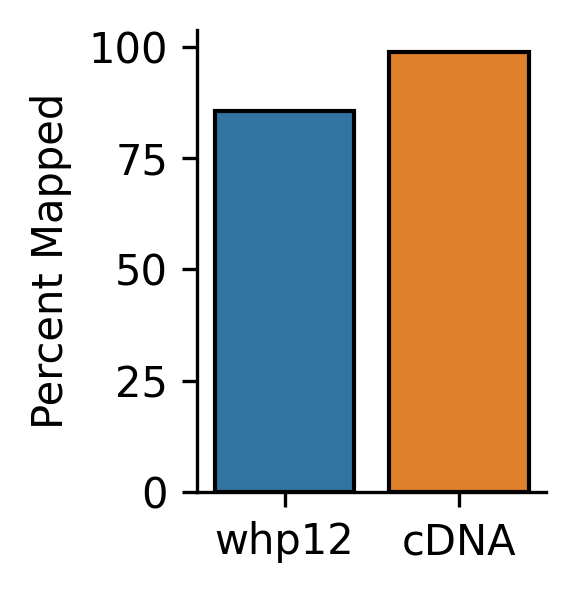

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2

sns.barplot(data=df, 
            x='file',
            edgecolor='k',
            y='Percent Mapped')

plt.xlabel("")
sns.despine()

# Feature Count Summary

In [4]:
results_path = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/direct_RNA_protocol_compairison_2023/"
sub_path = "counts/"

columns = ['Status', 'Read Count']

df = []

for f in os.listdir(f"{results_path}{sub_path}"):
    if f.endswith(".summary"):
        full_path = f"{results_path}{sub_path}{f}"
        tmp = pd.read_csv(full_path, sep='\t', header=None, skiprows=1)
        tmp.columns = columns
        tmp['file'] = f.replace(".bamstats", "")
        df.append(tmp)

df = pd.concat(df)
df = df[df['Read Count'] > 0]

mapper = {
    'Assigned' : 'Assigned',
    'Unassigned_Unmapped' : 'Unmapped',
    'Unassigned_NoFeatures' : 'No Feature',
    'Unassigned_Ambiguity' : 'Ambiguity',
}

df['label'] = df['Status'].map(mapper)

df

,Status,Read Count,file,label
0,Assigned,651967,whp12.featureCounts.summary,Assigned
1,Unassigned_Unmapped,135238,whp12.featureCounts.summary,Unmapped
11,Unassigned_NoFeatures,62985,whp12.featureCounts.summary,No Feature
13,Unassigned_Ambiguity,83467,whp12.featureCounts.summary,Ambiguity
0,Assigned,10607968,cDNA.featureCounts.summary,Assigned
1,Unassigned_Unmapped,151472,cDNA.featureCounts.summary,Unmapped
11,Unassigned_NoFeatures,563015,cDNA.featureCounts.summary,No Feature
13,Unassigned_Ambiguity,1818758,cDNA.featureCounts.summary,Ambiguity


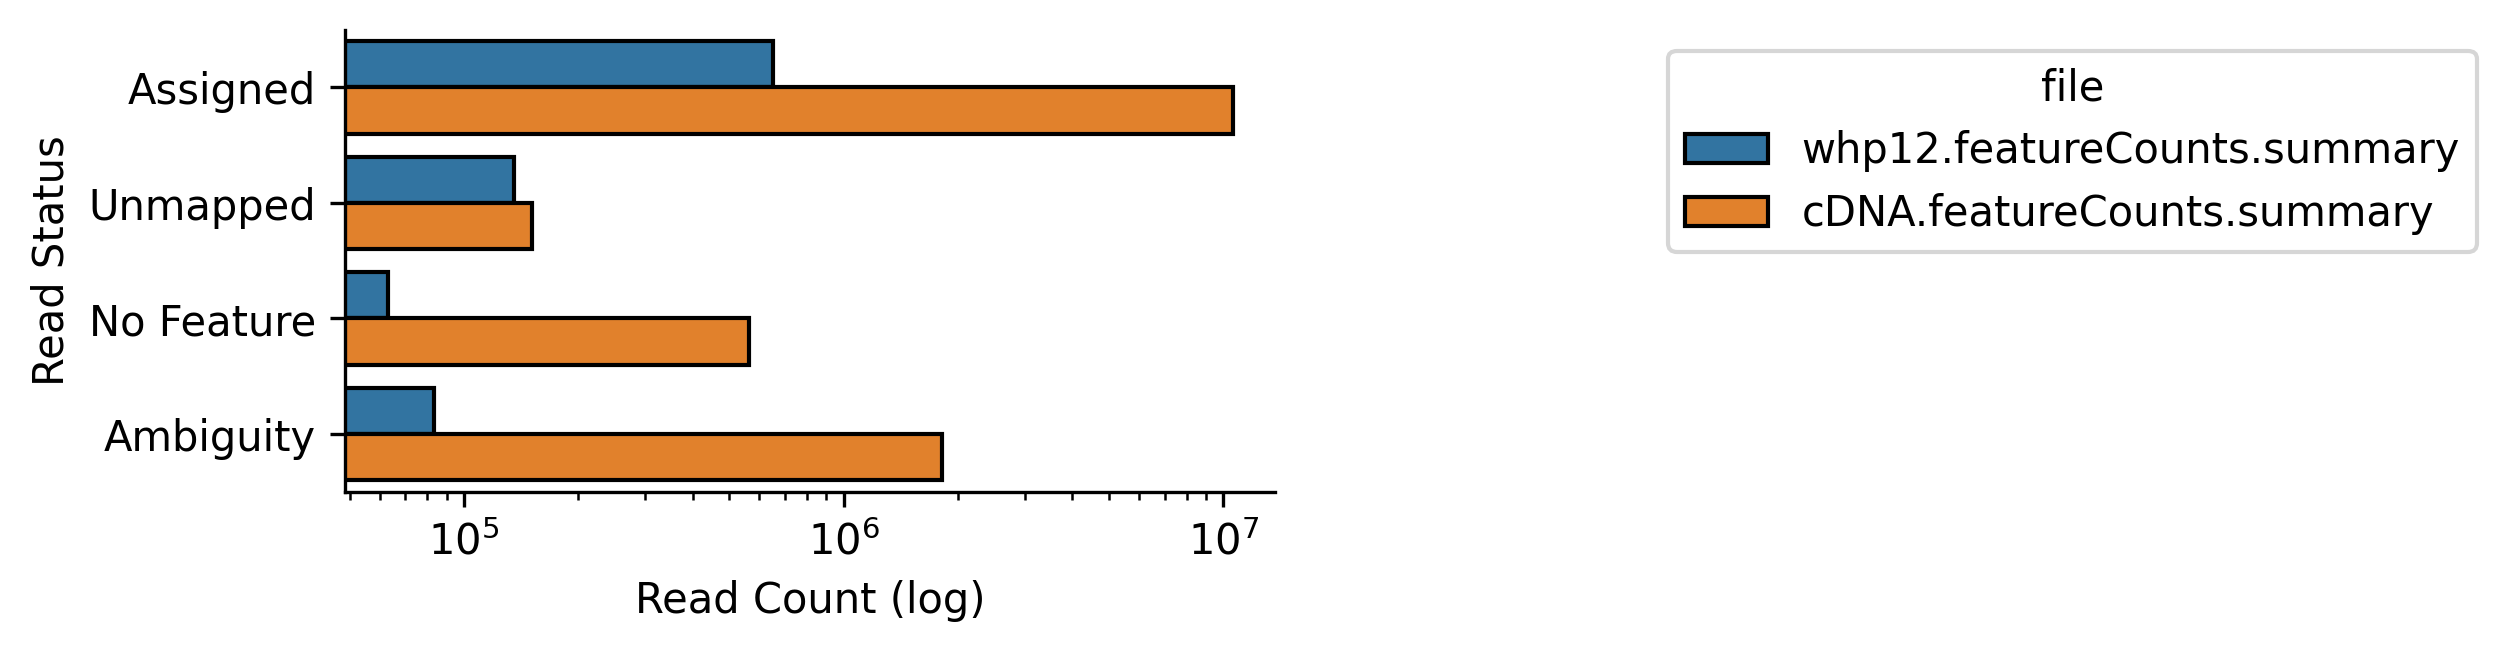

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(data=df, 
            x='Read Count',
            hue='file',
            edgecolor='k',
            y='label')

plt.xlabel("Read Count (log)")
plt.ylabel("Read Status")
plt.xscale("log")
sns.move_legend(plt.gca(),
                loc='upper left',
                bbox_to_anchor=(1.4, 1))
sns.despine()

# Feature Counts

In [6]:
gdf = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/direct_RNA_protocol_compairison_2023/references/geneNames.csv")
print(f"{gdf.shape=}")
gdf = gdf[gdf['Feature'] == 'gene']
print()
print(gdf.columns)
gdf.head()

/tmp/ipykernel_807977/1528140386.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/direct_RNA_protocol_compairison_2023/references/geneNames.csv")


gdf.shape=(3371244, 26)

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype', 'tag',
       'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id',
       'protein_version', 'transcript_support_level'],
      dtype='object')


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,ccds_id,exon_number,exon_id,exon_version,protein_id,protein_version,transcript_support_level
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,ENSG00000160072,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,1,havana,gene,2212522,2220738,.,+,.,ENSG00000234396,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,1,havana,gene,629061,629433,.,+,.,ENSG00000225972,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,1,havana,gene,634375,634922,.,+,.,ENSG00000198744,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,1,havana,gene,182695,184174,.,+,.,ENSG00000279928,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
results_path = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/results/direct_RNA_protocol_compairison_2023/"
sub_path = "counts/"

df = []

for f in os.listdir(f"{results_path}{sub_path}"):
    if f.endswith(".featureCounts"):
        full_path = f"{results_path}{sub_path}{f}"
        tmp = pd.read_csv(full_path, sep='\t', comment="#")

        # rename count column
        columnNames = tmp.columns.to_list()
        columnNames[-1] = "counts"
        tmp.columns = columnNames        
        tmp['file'] = f

        # drop zero count genes
        tmp = tmp[tmp['counts'] > 0].reset_index()

        tmp = pd.merge(tmp, 
                       gdf[['gene_id', 'gene_name', 'gene_biotype', 'Chromosome']],
                       how='left',
                       left_on='Geneid',
                       right_on='gene_id')

    

        print(f"{f} mapped genes: {tmp['gene_name'].notna().sum()} unnamed genes: {tmp['gene_name'].isna().sum()}")

        # drop unnamed genes
        tmp = tmp[tmp['gene_name'].notna()].reset_index(drop=True)
        df.append(tmp)

df = pd.concat(df, ignore_index=True)
print(f"{df.shape=}")
df.head()

cDNA.featureCounts mapped genes: 16866 unnamed genes: 2561
whp12.featureCounts mapped genes: 13118 unnamed genes: 1087
df.shape=(29984, 13)


,index,Geneid,Chr,Start,End,Strand,Length,counts,file,gene_id,gene_name,gene_biotype,Chromosome
0,0,ENSG00000160072,1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...,1471765;1471784;1477274;1477274;1478026;147864...,1472089;1472089;1477350;1477350;1478745;147874...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,7686,4,cDNA.featureCounts,ENSG00000160072,ATAD3B,protein_coding,1
1,2,ENSG00000225972,1,629062,629433,+,372,481,cDNA.featureCounts,ENSG00000225972,MTND1P23,unprocessed_pseudogene,1
2,3,ENSG00000224315,1,8786211,8786913,-,703,1,cDNA.featureCounts,ENSG00000224315,RPL7P7,processed_pseudogene,1
3,4,ENSG00000198744,1,634376,634922,+,547,99,cDNA.featureCounts,ENSG00000198744,MTCO3P12,unprocessed_pseudogene,1
4,5,ENSG00000279928,1;1;1;1;1,182696;183132;183494;183740;183981,182746;183216;183571;183901;184174,+;+;+;+;+,570,9,cDNA.featureCounts,ENSG00000279928,DDX11L17,unprocessed_pseudogene,1


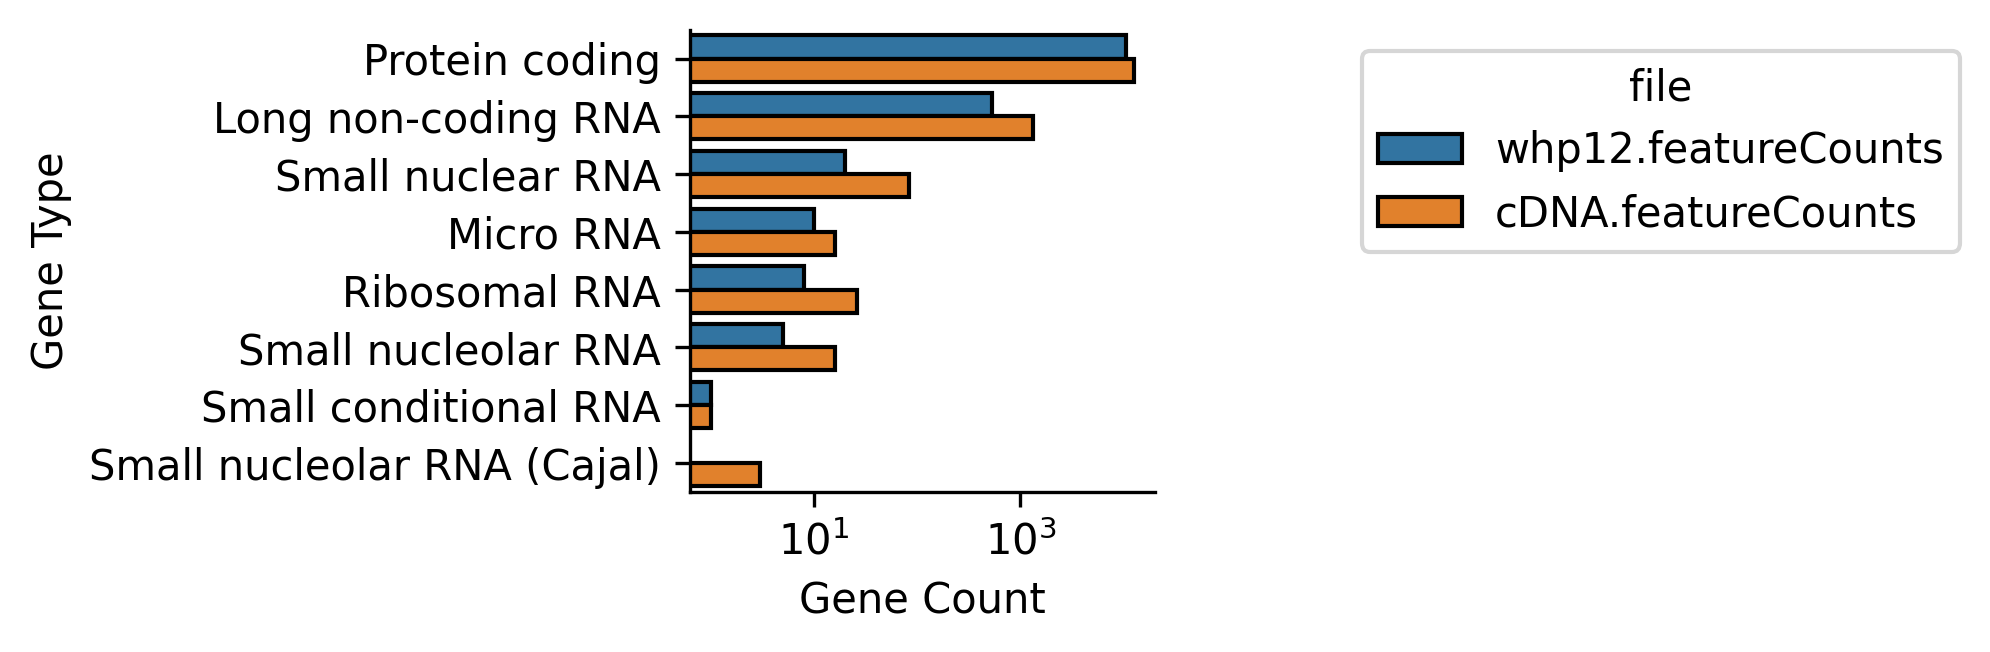

In [8]:
pdf = pd.DataFrame(df[['file', 'gene_biotype']].value_counts().reset_index())

biotypes = {
    'protein_coding' : 'Protein coding',
    'lncRNA' : 'Long non-coding RNA',
    'snRNA' : 'Small nuclear RNA',
    'rRNA' : 'Ribosomal RNA',
    'snoRNA' : 'Small nucleolar RNA',
    'miRNA' : 'Micro RNA',
    'scaRNA' : 'Small nucleolar RNA (Cajal)',
    'scRNA' : 'Small conditional RNA',
}

pdf['label'] = pdf['gene_biotype'].map(biotypes)
pdf = pdf[pdf['label'].notna()]
pdf = pdf.sort_values(by='file', ascending=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

sns.barplot(data=pdf, 
            x='count',
            hue='file',
            edgecolor='k',
            y='label')

plt.xlabel("Gene Count")
plt.ylabel("Gene Type")
plt.xscale("log")
sns.move_legend(plt.gca(),
                loc='upper left',
                bbox_to_anchor=(1.4, 1))
sns.despine()

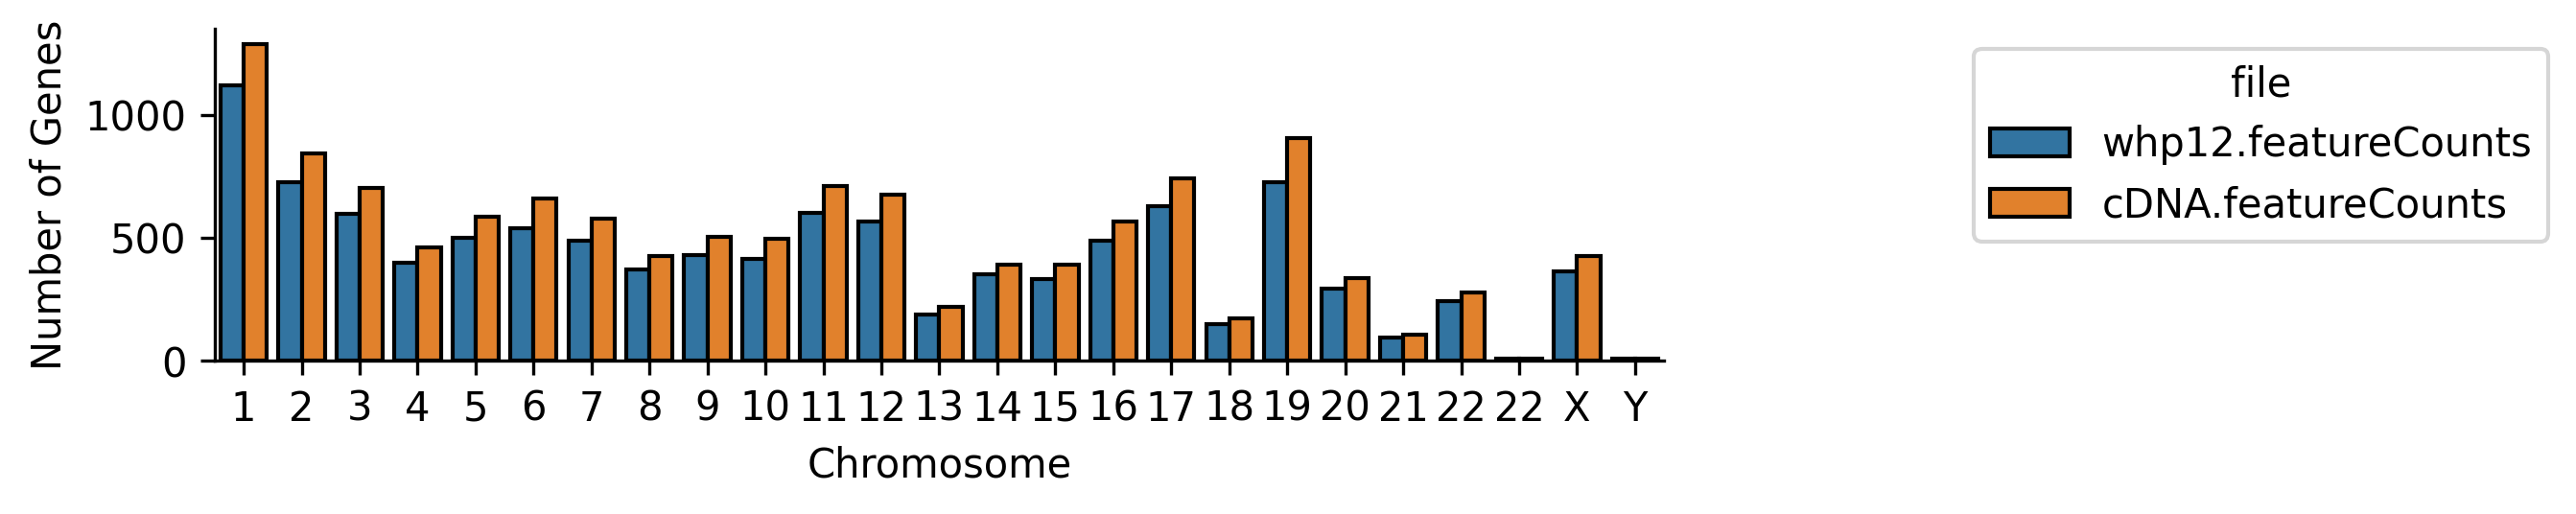

In [9]:
pdf = df.copy()

pdf = pdf[pdf['gene_biotype'] == 'protein_coding']
pdf = pdf[pdf['Chromosome'] != "MT"]

pdf = pdf.groupby(['file', 'Chromosome'])['gene_name'].nunique().reset_index()
pdf = pdf.sort_values(by=['Chromosome', 'file'], ascending=[True, False])
pdf.head()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.5, 1.5
sns.barplot(data=pdf, 
            x='Chromosome',
            y='gene_name',
            edgecolor='k',
            hue='file')

plt.ylabel("Number of Genes")
sns.move_legend(plt.gca(),
                loc='upper left',
                bbox_to_anchor=(1.2, 1))
sns.despine()

In [10]:
# load FB marker genes

def getGenes(pdf, cellType, ui_upper=None):
    """A function to get a cell-type specific list of marker genes"""
    genes = pdf[pdf['cell type'] == cellType]
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
        
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")
    
fbList = getGenes(pandDf, 'Fibroblasts')
len(fbList)

179

In [11]:
def normalize_column(series, target_sum=1e6):
    """a function to normalize counts """
    series_sum = series.sum()
    normed = (series / series_sum) 
    normed = normed * target_sum
    return normed

pval=0.184421826431863


Text(0.5, 1.0, 'FB Genes')

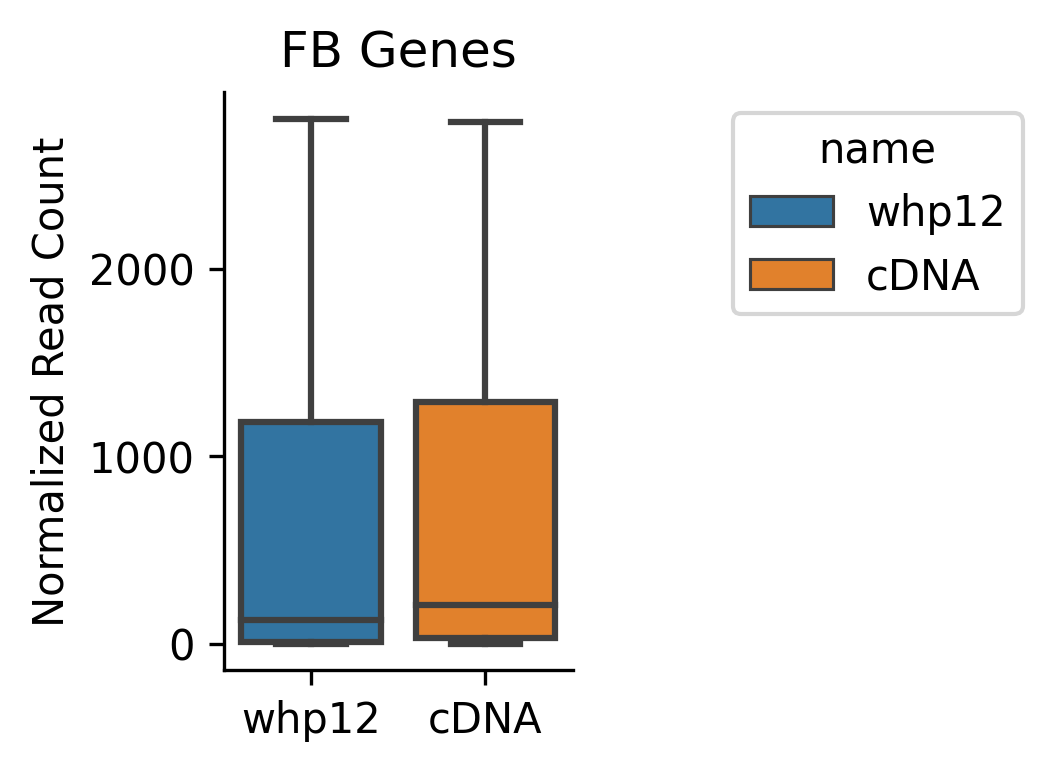

In [12]:
pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(fbList)]

pdf = pd.pivot_table(pdf, 
                     index='gene_name',
                     columns='file',
                     values='counts').reset_index()

pdf = pdf.fillna(0)

pdf['cDNA'] = normalize_column(pdf['cDNA.featureCounts'])
pdf['whp12'] = normalize_column(pdf['whp12.featureCounts'])
pdf.head()


score, pval= scipy.stats.ranksums(pdf['cDNA'], 
                                  pdf['whp12'])

print(f"{pval=}")

pdf = pd.melt(pdf, id_vars=['gene_name'])
pdf = pdf.sort_values(by='file', ascending=False)
pdf['name'] = pdf['file'].apply(lambda x: x.split(".")[0])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5

sns.boxplot(data=pdf, 
            x='name',
            y='value',
            hue='name',
            dodge=False, 
            showfliers=False,)

sns.despine()
plt.xlabel("")
plt.ylabel("Normalized Read Count")
# plt.xscale("log")
sns.move_legend(plt.gca(),
                loc='upper left',
                bbox_to_anchor=(1.4, 1))

plt.title("FB Genes")

In [13]:
def parseKEGG(pathId):
    genes = []
    results = REST.kegg_get(pathId).read()
    current_section = None
    for line in results.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            linesplit = line[12:].split("; ")
            gene_identifiers = linesplit[0]
            gene_id, gene_symbol = gene_identifiers.split()
    
            if not gene_symbol in genes:
                genes.append(gene_symbol)
    return genes

def getPathname(pathId):
    """A function to return the legg pathname"""
    result = REST.kegg_list(pathId).read()
    return result.split("\t")[1].split("-")[0].strip()


cell_cycle = parseKEGG('hsa04110')
print(f"{len(cell_cycle)=}")


len(cell_cycle)=157


pdf.shape=(292, 13)
pval=0.00022817218052882855


Text(0.5, 1.0, 'Cell Cycle Genes')

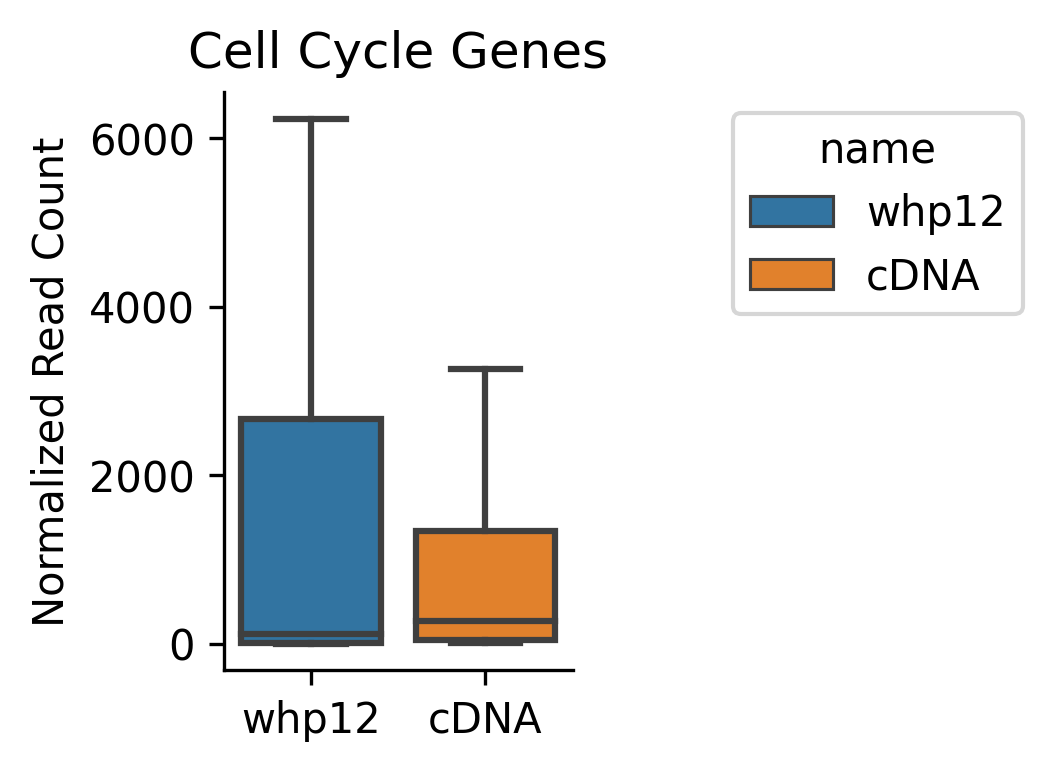

In [14]:
pdf = df.copy()

pdf = pdf[pdf['gene_name'].isin(cell_cycle)].reset_index(drop=True)
print(f"{pdf.shape=}")

pdf = pd.pivot_table(pdf, 
                     index='gene_name',
                     columns='file',
                     values='counts').reset_index()

pdf = pdf.fillna(0)
pdf['cDNA'] = normalize_column(pdf['cDNA.featureCounts'])
pdf['whp12'] = normalize_column(pdf['whp12.featureCounts'])
pdf.head()


score, pval= scipy.stats.ranksums(pdf['cDNA'], 
                                  pdf['whp12'])

print(f"{pval=}")

pdf = pd.melt(pdf, id_vars=['gene_name'])
pdf = pdf.sort_values(by='file', ascending=False)
pdf['name'] = pdf['file'].apply(lambda x: x.split(".")[0])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5

sns.boxplot(data=pdf, 
            x='name',
            y='value',
            hue='name',
            dodge=False, 
            showfliers=False,)

sns.despine()
plt.xlabel("")
plt.ylabel("Normalized Read Count")
# plt.xscale("log")
sns.move_legend(plt.gca(),
                loc='upper left',
                bbox_to_anchor=(1.4, 1))

plt.title("Cell Cycle Genes")


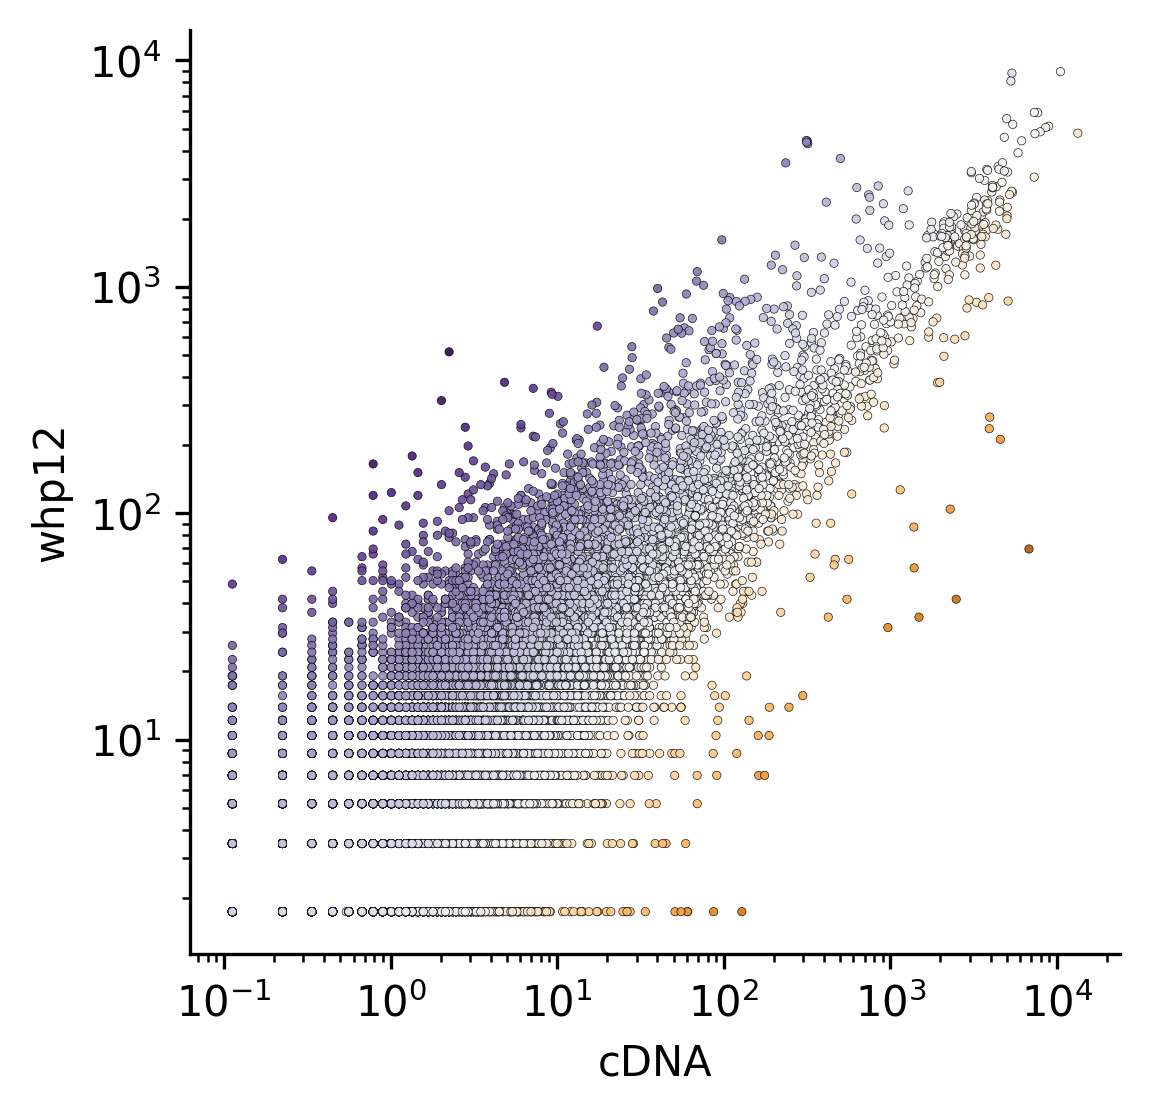

In [15]:
pdf = df.copy()


pdf = pd.pivot_table(pdf, 
                     index='gene_name',
                     columns='file',
                     values='counts').reset_index()

pdf = pdf.fillna(0)

# normalize the counts
pdf['cDNA'] = normalize_column(pdf['cDNA.featureCounts'])
pdf['whp12'] = normalize_column(pdf['whp12.featureCounts'])
pdf['lfc'] = np.log2((pdf['whp12'] + 1) / (pdf['cDNA'] + 1))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf,
                x='cDNA',
                y='whp12',
                hue='lfc',
                s=4,
                ec='k',
                palette='PuOr',
                alpha=0.9)

plt.yscale("log")
plt.xscale("log")
sns.despine()


# n = 10

# pdf = pdf.sort_values(by='lfc')
# # filter out genes with zero expression in one protocol
# pdf['x'] = pdf['cDNA'] * pdf['whp12']
# pdf = pdf[pdf['x'] > 0]
# extrema = pd.concat([pdf.head(n), pdf.tail(n)])

# for idx, row in extrema.iterrows():
#     x = row['cDNA']
#     y = row['whp12']
#     text = row['gene_name']

#     plt.annotate(text, [x, y], size=3)



# plt.gca().plot([0, 1], [0, 1], 
#                lw=1,
#                c='k',
#                ls='-',
#                transform=plt.gca().transAxes)

plt.gca().legend().remove()

# Raw expression

In [20]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/direct_RNA/bedfiles/cDNA.bed"
gr = pr.read_bed(fpath)
gr.head()

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,BlockCount
0,1,77129099,77129737,18,49488483,49492406,da39b15c-7b04-42c4-86aa-630a354d0191,0,+,-
1,1,52772124,52772646,11,17074388,17077639,a988537e-f88f-45cb-9062-3f27476a800c,0,+,+
2,1,44775573,44778703,5,33162155,33162825,9f0d7d7c-cd01-4314-ba25-59c01f14dfe8,0,-,-
3,1,212051451,212052036,10,120354643,120355213,712a166a-168d-4c82-b0c7-40fcac5dd5bc,0,-,-
4,1,212051442,212052036,10,120354643,120355213,8c33de34-6da2-4207-aee0-9b3923404e97,0,-,-
5,1,52772421,52772672,11,17075547,17077665,7ffd53b2-fb7f-4e16-ac41-b7355503f10a,0,-,-
6,1,52772124,52772675,11,17074388,17077667,d6a6af38-0d7e-4b3c-955d-4e016b344ceb,0,-,-
7,1,202471795,202472150,12,3211592,3211952,6131f2a5-bc3c-4474-a4da-ec968d813802,0,+,+


<AxesSubplot: xlabel='Start', ylabel='Score'>

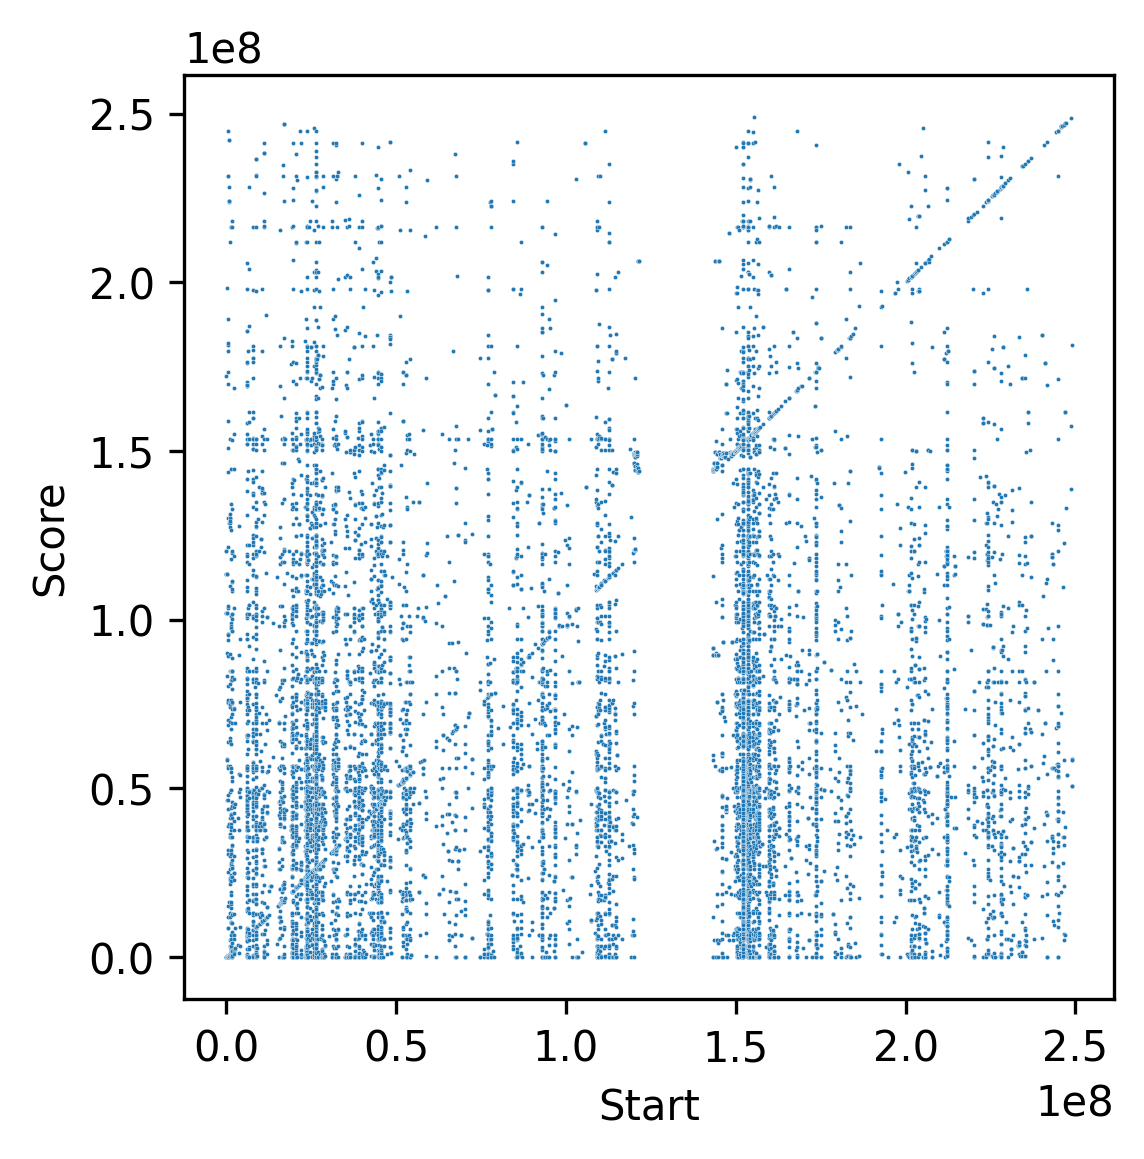

In [28]:
df = gr.df
df = df[df['Chromosome'] == '1']
df = df.sort_values(by='Start', ascending=True)

sns.scatterplot(data=df, 
             x='Start',
             y='Score',
              s=1)

In [ ]:
np.log2(3 / 2)

# Compairison with 2015 DATA

In [ ]:
array(['protein_coding', 'processed_pseudogene', 'lncRNA',
       'transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'snRNA', 'misc_RNA',
       'transcribed_unitary_pseudogene', 'rRNA', 'snoRNA', 'miRNA',
       'rRNA_pseudogene', 'TR_V_gene', 'scaRNA', 'Mt_tRNA', 'TR_C_gene',
       'Mt_rRNA', 'translated_processed_pseudogene', 'TR_J_gene', 'TEC',
       'scRNA', 'translated_unprocessed_pseudogene', 'unitary_pseudogene'],
      dtype=object)